Machine Learning

In [1]:
# imports para a criacao do modelo de machine learning

import pandas as pd
import numpy as np
import sqlite3
from scipy.stats import zscore
import seaborn as sns                   
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 5

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import xgboost as xgb
import lightgbm as lgb

from yellowbrick.features import FeatureImportances
import pydotplus
from io import StringIO
dot_data = StringIO()

import pickle

In [2]:
# conexao com o banco de dados

conn = sqlite3.connect('houseprices.db')

In [3]:
# consulta ao banco de dados
# busca apenas os imoveis anunciados em bairros com mais de 100 anauncios 

df = pd.read_sql("""

with filtro as (
                select 
                    area
                    ,quarto
                    ,banheiro
                    ,vagas_garagem
                    ,valor_imovel
                    ,bairro
                    ,link
                    ,count(*) over (partition by bairro) as controle
                from house_prices_cleaned_20221220
                where bairro not in ('Paraíso', 'Vila Dom Pedro I')
                )

select  
     area
    ,quarto
    ,banheiro
    ,vagas_garagem
    ,valor_imovel
    ,bairro
from filtro 
where controle >= 100


""", conn)

# verifica o tamanho do dataset

df.shape

(11433, 6)

In [4]:
# transforma bairros com one hot encoder

df = pd.get_dummies(df, columns=['bairro'])
df.columns = df.columns.str.replace(' ','_')

In [5]:
# Resumo das correlacoes por variavel com o valor do imovel usando o dataset limpo

pd.options.display.float_format = '{:,.4f}'.format
cor = df.corr()
cor_target = abs(cor["valor_imovel"])
variaveis = cor_target[cor_target>0.0]

print('Resumo das correlações:\n')
variaveis.sort_values(ascending=False)

Resumo das correlações:



valor_imovel                1.0000
area                        0.6607
banheiro                    0.4732
vagas_garagem               0.3878
quarto                      0.3497
bairro_Vila_Mariana         0.2597
bairro_Jardim_São_Caetano   0.1648
bairro_Vila_Prudente        0.1402
bairro_Ipiranga             0.1231
bairro_Aclimação            0.1216
bairro_Nova_Gerti           0.0862
bairro_Maua                 0.0718
bairro_Olímpico             0.0624
bairro_Fundaçao             0.0548
bairro_Boa_Vista            0.0473
bairro_Osvaldo_Cruz         0.0440
bairro_Santa_Maria          0.0405
bairro_Saúde                0.0321
bairro_Barcelona            0.0296
bairro_Ceramica             0.0272
bairro_Santa_Paula          0.0107
bairro_Santo_Antônio        0.0066
Name: valor_imovel, dtype: float64

A maior parte das variáveis apresentaram baixa correlação, sendo a área a variável que apresenta melhor correlação com o valor do imóvel.

In [7]:
# apresenta os dados do DataFrame

df = df.astype(float)

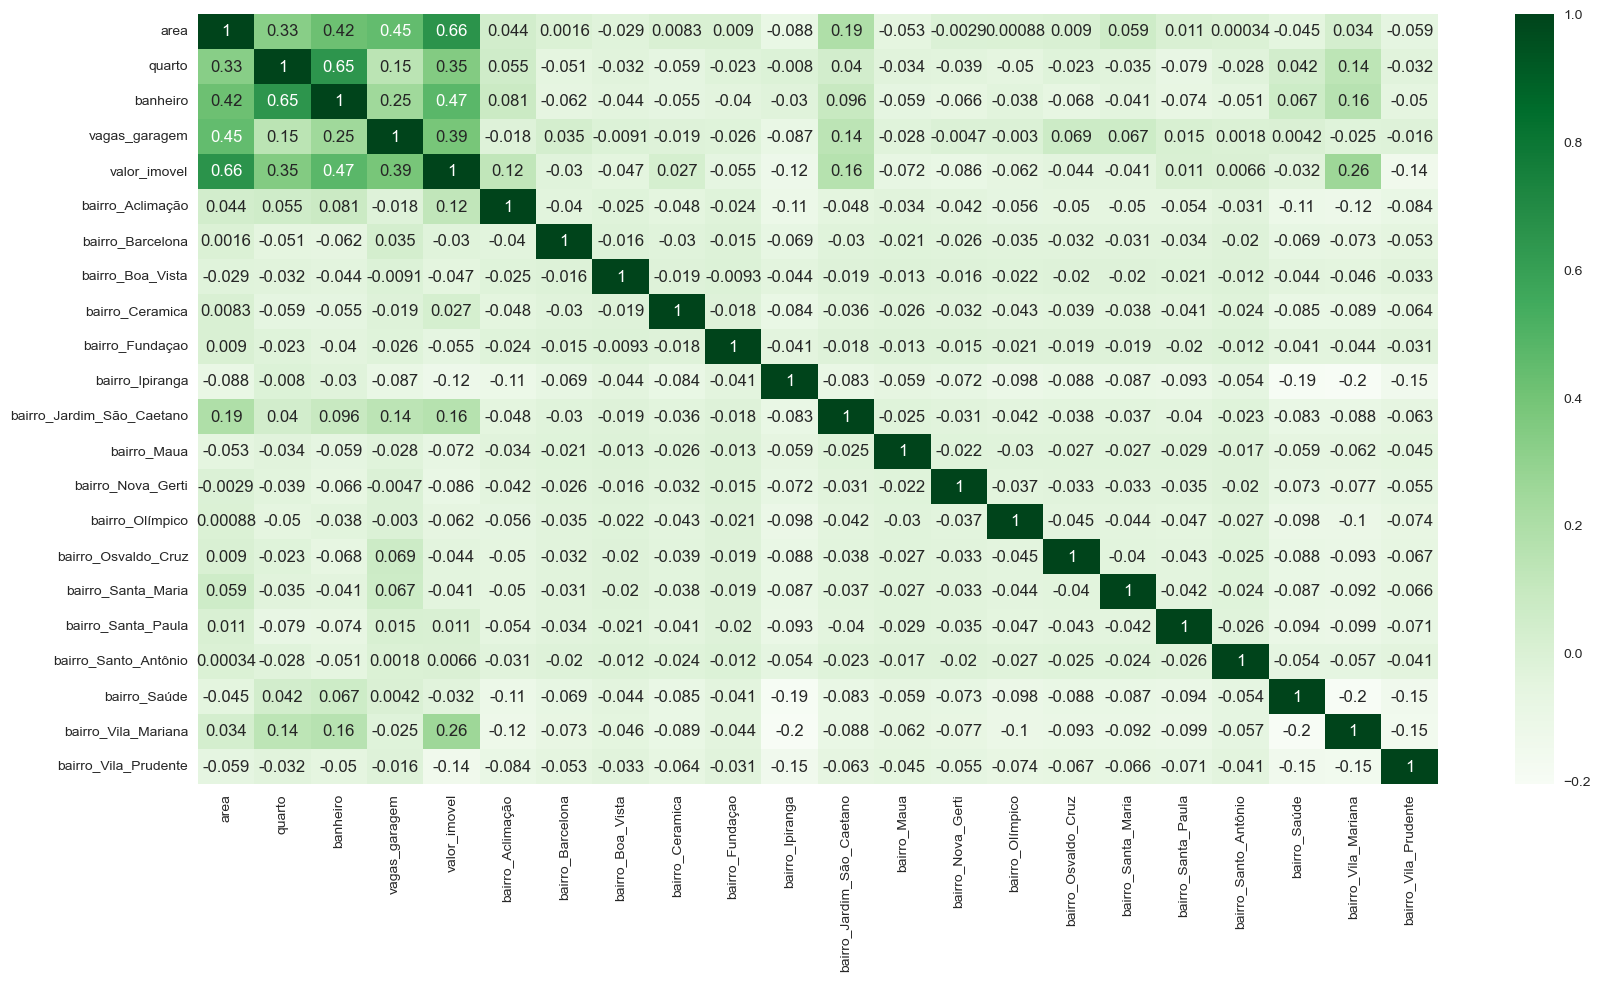

In [8]:
# Correlacao entre as variaveis

plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens)
plt.show()

As variáveis área, quarto, banheiro e vagas na garagem parecem estar correlacionadas também. Se o modelo fosse construído com o objetivo de explicar correlação, possivelmente algumas dessas variáveis seriam descartadas, mas o objetivo desse modedo é apenas previsão, sendo assim não haverá problema algum em mantê-las como estão. 

In [9]:
# criar dicionário

resultados = {}

In [10]:
# ver colunas

df.columns

Index(['area', 'quarto', 'banheiro', 'vagas_garagem', 'valor_imovel',
       'bairro_Aclimação', 'bairro_Barcelona', 'bairro_Boa_Vista',
       'bairro_Ceramica', 'bairro_Fundaçao', 'bairro_Ipiranga',
       'bairro_Jardim_São_Caetano', 'bairro_Maua', 'bairro_Nova_Gerti',
       'bairro_Olímpico', 'bairro_Osvaldo_Cruz', 'bairro_Santa_Maria',
       'bairro_Santa_Paula', 'bairro_Santo_Antônio', 'bairro_Saúde',
       'bairro_Vila_Mariana', 'bairro_Vila_Prudente'],
      dtype='object')

In [11]:
# selecionando os atributos e variaveis preditivas

atributos = [
              'area'
             ,'quarto'
             ,'banheiro'
             ,'vagas_garagem'
             ,'bairro_Aclimação'
             ,'bairro_Barcelona'
             ,'bairro_Boa_Vista'
             ,'bairro_Ceramica'
             ,'bairro_Fundaçao'
             ,'bairro_Ipiranga'
             ,'bairro_Jardim_São_Caetano'
             ,'bairro_Maua'
             ,'bairro_Nova_Gerti'
             ,'bairro_Olímpico'
             ,'bairro_Osvaldo_Cruz'
             ,'bairro_Santa_Maria'
             ,'bairro_Santa_Paula'
             ,'bairro_Santo_Antônio'
             ,'bairro_Saúde'
             ,'bairro_Vila_Mariana'
             ,'bairro_Vila_Prudente'                      
            ]

atrib_prev = ['valor_imovel']

In [12]:
# A variavel area é muito diferente das demais e poderá perder o seu efeito preditivo, caso se mantenha como está.
# Deixá-la mais próxima das outras varáveis pode favorecer a variável, desse modo o tratamento escolhido foi tirar o log da variável.

df['area'] = np.log(df['area'])

In [13]:
# Exibe o tamanho do dataframe

df.shape

(11433, 22)

In [54]:
# separarando as variaveis x e y

x = df[atributos].values
y = df[atrib_prev].values

In [14]:
# definindo o tamanho da base de teste

split_teste_size = 0.30

In [15]:
# criando bases de treino e de teste

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = split_teste_size, random_state = 42)

In [16]:
# exibe as proporcoes de treino e teste

print("{0:0.2f}% nos dados de treino".format((len(x_treino)/len(df.index))*100))
print("{0:0.2f}% nos dados de teste".format((len(x_teste)/len(df.index))*100))

70.00% nos dados de treino
30.00% nos dados de teste


In [17]:
# Modelo 0 - DummyRegressor
# Esse primeiro modelo é o nosso baseline, ele faz uma previsao aleatoria.

modelo0 = DummyRegressor()
modelo0.fit(x_treino,y_treino);

y_pred = modelo0.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['Linear_Regression'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : -7.861183638824265e-05 - MAE : 590796.9627580255  - MSE : 825038781560.8196  - RMSE: 908316.4545249742


In [18]:
# Modelo 1 - LinearRegression

modelo1 = LinearRegression()
modelo1.fit(x_treino,y_treino);

y_pred = modelo1.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['Linear_Regression'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : 0.5057939821869575 - MAE : 386609.95854966063  - MSE : 407707080174.2163  - RMSE: 638519.4438497674


c:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


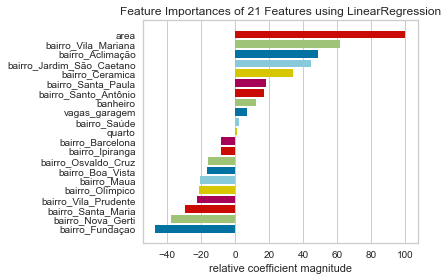

In [19]:
# o grafico abaixo mostra a importancia de cada variavel no modelo

fig, ax = plt.subplots(figsize=(6,4));
fi_viz = FeatureImportances(modelo1, labels=atributos);
fi_viz.fit(x,y);
fi_viz.poof();


In [20]:
# Modelo 2 - RandomForestRegressor

modelo2 = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, random_state=30, max_depth=10)
modelo2.fit(x_treino, y_treino.ravel());

y_pred = modelo2.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['RandomForest_Regressor'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : 0.7121667893321104 - MAE : 301051.0648901292  - MSE : 237454894656.84598  - RMSE: 487293.4379373951


In [21]:
# Modelo 3 - KNeighborsRegressor

modelo3 = KNeighborsRegressor(n_neighbors=7,metric='sqeuclidean')
modelo3.fit(x_treino,y_treino);

y_pred = modelo3.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['KNeighbors_Regressor'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : 0.5592001340352706 - MAE : 342924.6151603499  - MSE : 363648397259.40466  - RMSE: 603032.6668261054


In [22]:
# Modelo 4 - DecisionTreeRegressor

modelo4 = DecisionTreeRegressor(random_state=26)
modelo4.fit(x_treino,y_treino);

y_pred = modelo4.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['Decision_Tree_Regressor'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : 0.5696002231771718 - MAE : 313368.6444146045  - MSE : 355068594859.66907  - RMSE: 595876.3251377495


In [23]:
# Modelo 5 - Ensemble - BaggingRegressor

modelo_base = DecisionTreeRegressor(random_state=26)
modelo5 = BaggingRegressor(base_estimator=modelo_base, n_estimators=10, random_state=26)
modelo5.fit(x_treino,y_treino.ravel());

y_pred = modelo5.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['Bagging_Regressor'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


R2  : 0.7349737481822343 - MAE : 271590.86640545767  - MSE : 218639748209.24622  - RMSE: 467589.2943697987


In [24]:
# Modelo 6 - Ensemble - VotingRegressor

r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, random_state=42, max_depth=10)
modelo6 = VotingRegressor([('LR', r1), ('RF', r2)])
modelo6.fit(x_treino, y_treino.ravel());

y_pred = modelo6.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['Voting_Regressor'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : 0.6558279237640261 - MAE : 328778.1998357883  - MSE : 283932989931.23566  - RMSE: 532853.628993212


In [25]:
# Modelo 7 - LinearRegression

modelo7 = Lasso()
modelo7.fit(x_treino,y_treino);

y_pred = modelo7.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['Lasso'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : 0.5057927671369851 - MAE : 386608.49950772495  - MSE : 407708082558.7658  - RMSE: 638520.2287780441


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e+14, tolerance: 5.803e+11
  model = cd_fast.enet_coordinate_descent(


In [26]:
# Modelo 8 - DecisionTreeRegressor

modelo8 = DecisionTreeRegressor(min_samples_leaf=2, random_state=30, max_depth=10)
modelo8.fit(x_treino, y_treino.ravel());

y_pred = modelo8.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['Decision_TreeRegressor'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : 0.6213682157669892 - MAE : 334114.0598777553  - MSE : 312361350624.413  - RMSE: 558892.9688450312


In [107]:
# Modelo 9 - xgboost

modelo9 = xgb.XGBRegressor(
                             random_state=42
                            ,objective='reg:squarederror'
                            ,n_estimators=200
                            ,booster='gbtree'
                            ,max_depth=9
                            ,learning_rate=0.1
                          )
modelo9.fit(x_treino, y_treino.ravel());

y_pred = modelo9.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['XGB_Regressor'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)


R2  : 0.7466482374630856 - MAE : 268037.5909894315  - MSE : 209008598919.95984  - RMSE: 457174.5825392744


In [29]:
# Modelo 10 - LGBMRegressor

modelo10 = lgb.LGBMRegressor(
                             random_state=42
                            ,n_estimators=2000
                            ,boosting_type='gbdt'
                            ,num_leaves=11
                            , max_depth=8
                            ,learning_rate=0.04
                            )
modelo10.fit(x_treino, y_treino.ravel());

y_pred = modelo10.predict(x_teste)

r2 = metrics.r2_score(y_teste,y_pred)
mae = metrics.mean_absolute_error(y_teste,y_pred)
mse = metrics.mean_squared_error(y_teste,y_pred, squared=True)
rmse = metrics.mean_squared_error(y_teste,y_pred, squared=False)

resultados['LGBM_Regressor'] = {'R2':r2, 'MAE':mae, 'MSE':mse, 'RMSE':rmse}
print('R2  :',r2, '- MAE :',mae, ' - MSE :',mse, ' - RMSE:',rmse)

R2  : 0.7326233416163166 - MAE : 298684.26452049945  - MSE : 220578772348.3151  - RMSE: 469658.14413072314


In [30]:
# apresenta os resultados dos modelos em uma tabela para facilitar nossa escolha

print("Comparação entre os modelos:")
cm = sns.color_palette('Reds', as_cmap=True)
pd.DataFrame(resultados).T.style.background_gradient(subset=['R2'], cmap=cm)

Comparação entre os modelos:


,R2,MAE,MSE,RMSE
Linear_Regression,0.505794,386609.958550,407707080174.216309,638519.443850
RandomForest_Regressor,0.712167,301051.064890,237454894656.845978,487293.437937
KNeighbors_Regressor,0.559200,342924.615160,363648397259.404663,603032.666826
Decision_Tree_Regressor,0.569600,313368.644415,355068594859.669067,595876.325138
Bagging_Regressor,0.734974,271590.866405,218639748209.246216,467589.294370
Voting_Regressor,0.655828,328778.199836,283932989931.235657,532853.628993
Lasso,0.505793,386608.499508,407708082558.765808,638520.228778
Decision_TreeRegressor,0.621368,334114.059878,312361350624.413025,558892.968845
XGB_Regressor,0.746648,268037.590989,209008598919.959839,457174.582539
LGBM_Regressor,0.732623,298684.264520,220578772348.315094,469658.144131


In [31]:
# salvar o modelo para usar posteriormente

arquivo = 'modelo_treinado_20221220.sav'
pickle.dump(modelo9,open(arquivo,'wb'))

O modelo escolhido foi o XGB_Regressor, pois apresentou melhor precisão dentre os modelos com o menor RMSE.